In [152]:
import pandas as pd
import os
import hvplot.pandas
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
from dotenv import load_dotenv
from pathlib import Path
import numpy as np
import quantstats as qs

In [92]:
load_dotenv()

True

In [93]:
alpaca_api_key = os.getenv('ALPACA_API_KEY')
alpaca_secret_key = os.getenv('ALPACA_SECRET_KEY')

alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version='v2')

In [94]:
tickers = ['BTCUSD', 'ETHUSD']

start_date = pd.Timestamp('2016-01-04', tz="America/New_York").isoformat()
end_date = pd.Timestamp('2022-05-30', tz="America/New_York").isoformat()

timeframe = "1Day"

In [95]:
crypto_df = alpaca.get_crypto_bars(
    tickers,
    timeframe,
    '2016-01-04',
    '2022-05-30',
    limit = 10000,
    exchanges = 'CBSE' 
    ).df

In [96]:
SPY = alpaca.get_bars(
    'SPY',
    timeframe,
    start = start_date,
    end = end_date,
    limit = 10000
).df

In [97]:
# Removing exchange column from crypto_af
crypto_df = crypto_df.drop(columns='exchange')

In [98]:
# Seperating BTC & ETH in to seperate dataframes
BTC = crypto_df[crypto_df['symbol']=='BTCUSD'].drop('symbol', axis=1)
ETH = crypto_df[crypto_df['symbol']=='ETHUSD'].drop('symbol', axis=1)

In [99]:
# Converting timestamp to pandas datetime & removing time(hours/seconds)
SPY.index = pd.to_datetime(SPY.index)
SPY.index = SPY.index.date
ETH.index = pd.to_datetime(ETH.index)
ETH.index = ETH.index.date
BTC.index = pd.to_datetime(BTC.index)
BTC.index = BTC.index.date

In [ ]:
prices_df = pd.concat([SPY, BTC, ETH], axis=1, keys=['SPY', 'BTC', 'ETH']).dropna()
prices_df

In [101]:
closing_prices_df = pd.DataFrame()
assets = ['SPY', 'BTC', 'ETH']
for asset in assets:
    closing_prices_df[asset] = prices_df[asset]["close"]
display(closing_prices_df.head())
display(closing_prices_df.tail())

,SPY,BTC,ETH
2016-05-17,204.82,456.21,14.00
2016-05-18,204.91,456.20,13.18
2016-05-19,204.24,440.72,14.82
2016-05-20,205.49,445.65,14.17
2016-05-23,205.16,447.42,13.74


,SPY,BTC,ETH
2022-05-23,397.05,29322.98,1985.73
2022-05-24,393.89,30069.27,2003.68
2022-05-25,397.37,29733.94,1936.05
2022-05-26,405.31,28890.69,1743.00
2022-05-27,415.26,28576.21,1720.72


In [121]:
#Daily Returns
daily_returns_df=closing_prices_df.pct_change().dropna()
daily_returns_df.head()

,SPY,BTC,ETH
2016-05-18,0.000439,-0.000022,-0.058571
2016-05-19,-0.003270,-0.033932,0.124431
2016-05-20,0.006120,0.011186,-0.043860
2016-05-23,-0.001606,0.003972,-0.030346
2016-05-24,0.013209,-0.000961,-0.058224


<AxesSubplot:title={'center':'Daily Returns'}>

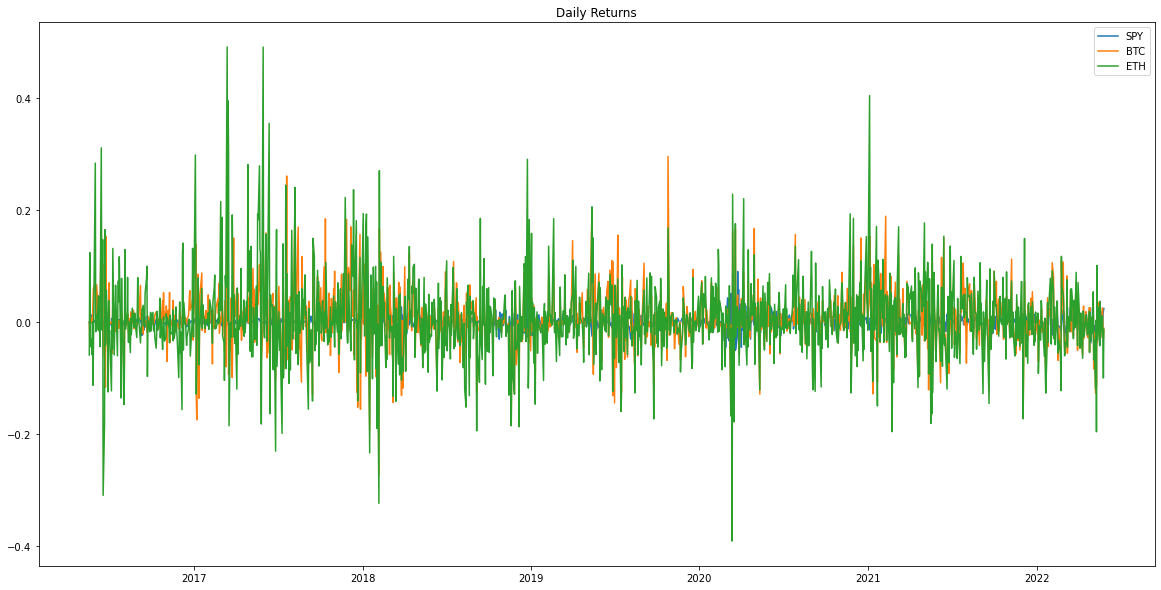

In [122]:
daily_returns_df.plot(figsize=(20,10), title="Daily Returns")

In [120]:
all_cumulative_returns_df = (1 + daily_returns_df).cumprod()
all_cumulative_returns_df.tail(1)

,SPY,BTC,ETH
2022-05-27,2.027439,62.638281,122.908571


<AxesSubplot:title={'center':'Cumulative Returns'}>

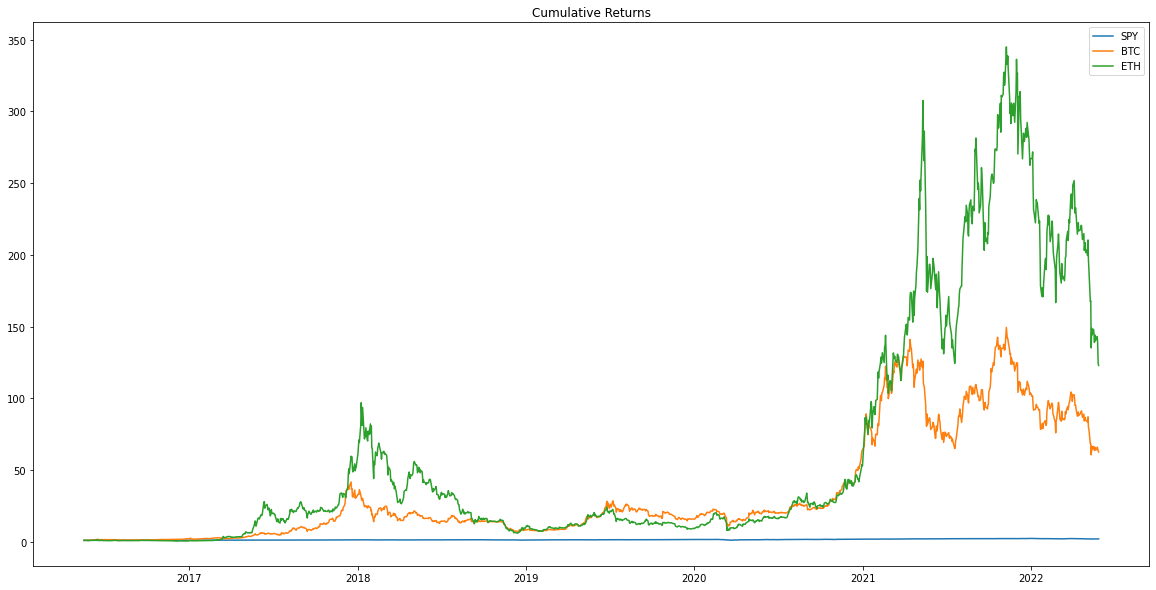

In [106]:
all_cumulative_returns_df.plot(figsize=(20,10), title="Cumulative Returns")

<AxesSubplot:title={'center':'SPY, BTC, ETC Volatility'}>

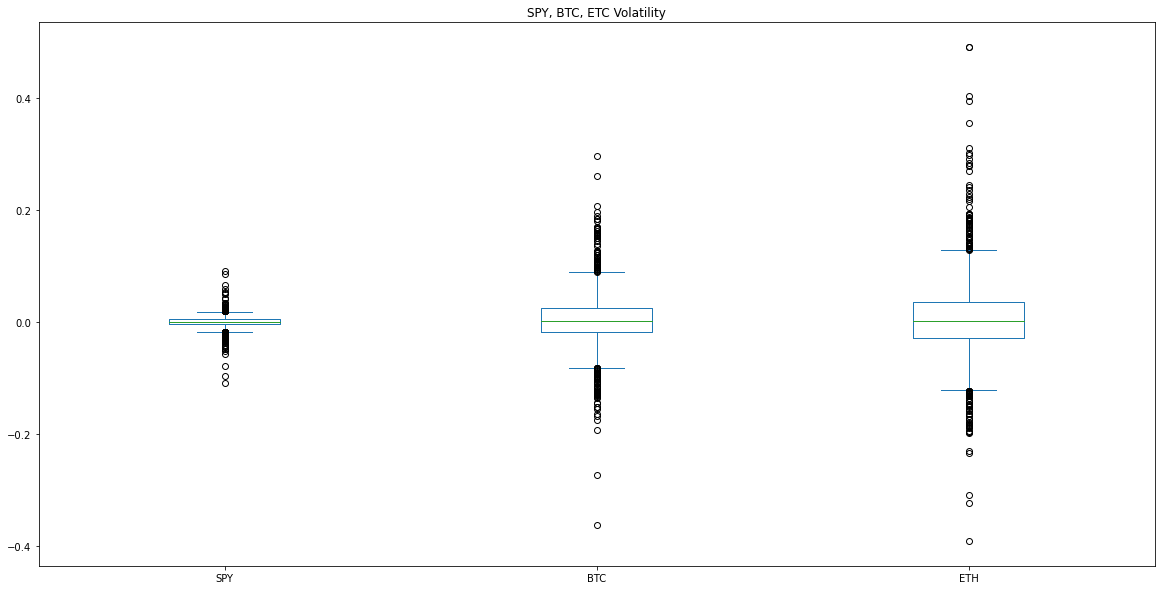

In [107]:
daily_returns_df.plot.box(figsize=(20,10), title="SPY, BTC, ETC Volatility")

In [108]:
#Based on Volatility, ETH has the most volatility

<AxesSubplot:title={'center':'21 Day Rolling Standard Deviation'}>

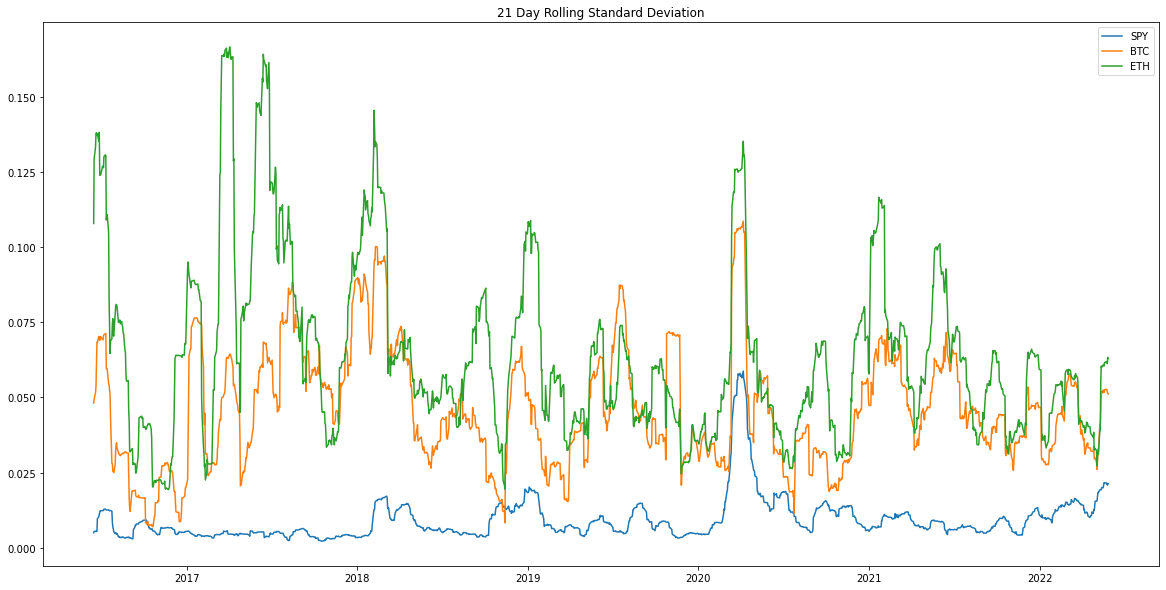

In [109]:
### Rolling window
daily_returns_df.rolling(window=21).std().plot(figsize=(20,10), title="21 Day Rolling Standard Deviation")

In [110]:
all_standard_deviations = daily_returns_df.std()
all_standard_deviations.sort_values()

all_annual_standard_deviations = all_standard_deviations * np.sqrt(252)
all_annual_standard_deviations.sort_values()

SPY    0.187040
BTC    0.792054
ETH    1.129572
dtype: float64

In [119]:
spy_21rolling_variance = daily_returns_df['SPY'].rolling(window=21).var()
eth_21rolling_covariance = daily_returns_df['ETH'].rolling(window=21).cov(daily_returns_df['SPY'])
btc_21rolling_covariance = daily_returns_df['BTC'].rolling(window=21).cov(daily_returns_df['SPY'])
eth_21rolling_beta = eth_21rolling_covariance / spy_21rolling_variance
btc_21rolling_beta = btc_21rolling_covariance / spy_21rolling_variance

<AxesSubplot:title={'center':'ETH 21 Day Rolling Beta'}>

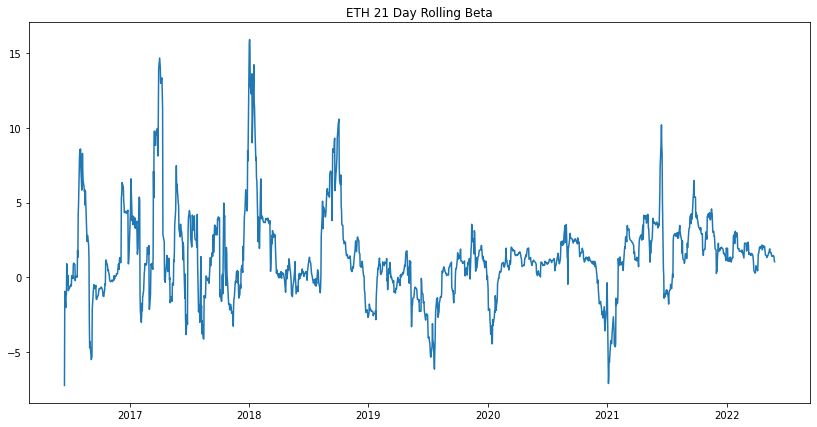

In [113]:
eth_21rolling_beta.plot(figsize=(14,7), title='ETH 21 Day Rolling Beta')

<AxesSubplot:title={'center':'BTC 21 Day Rolling Beta'}>

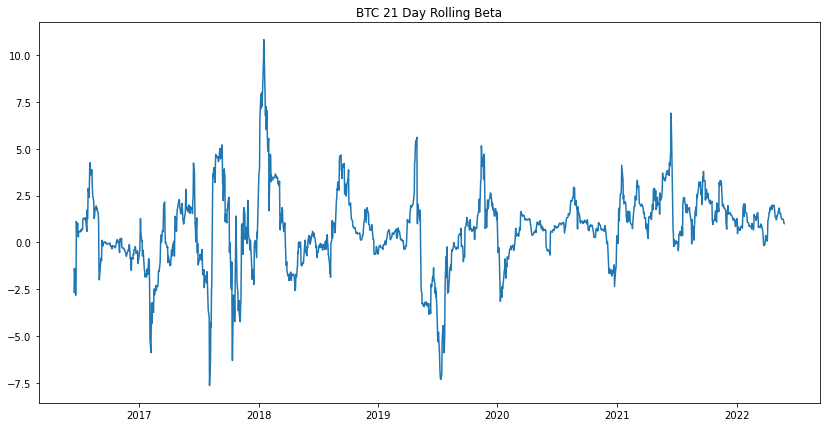

In [114]:
btc_21rolling_beta.plot(figsize=(14,7), title='BTC 21 Day Rolling Beta')

In [144]:
# Calculate the annual average return data for the for SPY,BTC,ETC 
all_annual_average_returns = daily_returns_df.mean() * 252
all_annual_average_returns.sort_values()

SPY    0.134876
BTC    1.002972
ETH    1.420953
dtype: float64

In [158]:
#Sharpe Ratio
sharpe_ratios = all_annual_average_returns / all_annual_standard_deviations
sharpe_ratios


SPY    0.721109
BTC    1.266291
ETH    1.257957
dtype: float64

<AxesSubplot:title={'center':'Sharpe Ratios'}>

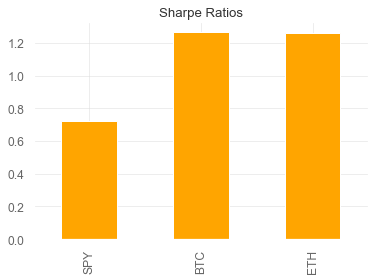

In [154]:
sharpe_ratios.plot(kind="bar", title="Sharpe Ratios", color="orange")

In [157]:
calmar_ratios = daily_returns_df.apply(qs.stats.calmar, axis=0)
calmar_ratios

SPY    0.364793
BTC    1.186874
ETH    1.301859
dtype: float64

<AxesSubplot:title={'center':'Calmar Ratios'}>

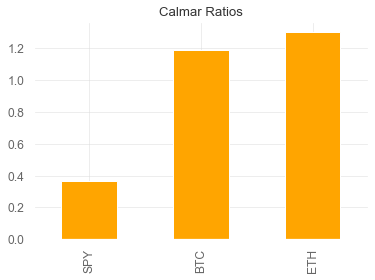

In [159]:
calmar_ratios.plot(kind="bar", title="Calmar Ratios", color="orange")